# DATA EXPLORATION

*"Giữa hàng ngàn lựa chọn lưu trú tại New York, những yếu tố định lượng nào (vị trí, loại phòng, số lượng review) thực sự chi phối mức giá niêm yết?"*

Đây là một trong những câu hỏi mà em đã đặt ra khi chọn Dataset **New York City Airbnb Open Data**. Và để trả lời cho câu hỏi này, cùng với những khám phá khác về mức giá, hành vi của chủ thuê và khách thuê, em sẽ thể hiện tất cả kết quả phân tích ở đây.

## I. IMPORT THƯ VIỆN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..")

import src


### PHIÊN BẢN NUMPY SỬ DỤNG

In [2]:
np.set_printoptions(suppress=True, precision=6, linewidth=150)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Numpy version:", np.__version__)

Numpy version: 2.2.3


## II. ĐỌC DỮ LIỆU

Quan sát ban đầu về dữ liệu, chiến lược thu thập, hạn chế, giải pháp

In [3]:
data, columns = src.load_data("../data/raw/AB_NYC_2019.csv")

Loaded: (48895, 16)


## III. KIỂM TRA DỮ LIỆU


In [4]:
print("Data shape:", data.shape)

Data shape: (48895, 16)


In [5]:
src.print_preview(data, columns, n=5, col_width=25)


id                        | name                      | host_id                   | host_name                 | neighbourhood_group       | neighbourhood             | latitude                  | longitude                 | room_type                 | price                     | minimum_nights            | number_of_reviews         | last_review               | reviews_per_month         | calculated_host_listings_ | availability_365          | 
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
2539                      | Clean & quiet apt home... | 2787                      | John              

### Mô tả Dữ liệu (48895 dòng, 16 cột)

| Index | Tên cột                           | Mô tả ngắn gọn                                                     |
|-------|------------------------------------|--------------------------------------------------------------------|
| 0     | **id**                             | Mã định danh của từng listing.                                     |
| 1     | **name**                           | Tên tiêu đề của chỗ ở trên Airbnb.                                 |
| 2     | **host_id**                        | Mã định danh của chủ nhà.                                          |
| 3     | **host_name**                      | Tên hiển thị của chủ nhà trên Airbnb.                              |
| 4     | **neighbourhood_group**            | Khu vực lớn/ quận (ví dụ: Manhattan, Brooklyn).                    |
| 5     | **neighbourhood**                  | Khu phố cụ thể nơi listing nằm.                                    |
| 6     | **latitude**                       | Vĩ độ vị trí của listing.                                          |
| 7     | **longitude**                      | Kinh độ vị trí của listing.                                        |
| 8     | **room_type**                      | Loại phòng cho thuê (nhà nguyên căn, phòng riêng, phòng chung…).   |
| 9     | **price**                          | Giá thuê theo đêm (USD).                                           |
| 10    | **minimum_nights**                 | Số đêm tối thiểu phải đặt.                                         |
| 11    | **number_of_reviews**              | Tổng số đánh giá mà listing nhận được.                             |
| 12    | **last_review**                    | Ngày đánh giá gần nhất.                                            |
| 13    | **reviews_per_month**              | Số lượng đánh giá trung bình mỗi tháng.                            |
| 14    | **calculated_host_listings_count** | Số lượng listing khác của cùng chủ nhà.                            |
| 15    | **availability_365**               | Số ngày trống để đặt trong 1 năm (0–365).                          |


## IV. LÀM SẠCH DỮ LIỆU 

### 1. Kiểm tra Dữ liệu trùng

In [6]:
#trùng id
ids = data[:, 0]
unique_ids = set(ids)
print(f"Total IDs: {len(ids)}")
print(f"Unique IDs: {len(unique_ids)}")
print(f"Duplicate IDs: {len(ids) - len(unique_ids)}")

Total IDs: 48895
Unique IDs: 48895
Duplicate IDs: 0


==> Dữ liệu sạch, không có trùng.

### 2. Kiểm tra Dữ liệu thiếu

In [7]:
id_col_idx = [0, 2]   
date_col_idx = [12]   
cat_cols_idx = [1, 3, 4, 5, 8] 
num_cols_idx = [6, 7, 9, 10, 11, 13, 14, 15]

column_groups = {
    "ID": id_col_idx,
    "Date": date_col_idx,
    "Categorical": cat_cols_idx,
    "Numeric": num_cols_idx
}

missing_list = src.count_missing(data, columns, column_groups)

print("Columns with missing data:")
for idx, col_type, col_name, miss in missing_list:
    if miss > 0:
        print(f"  Index: {idx:<2} | Name: {col_name:<30} | Type: {col_type:<12} | Missing Count: {miss}")

Columns with missing data:
  Index: 12 | Name: last_review                    | Type: Date         | Missing Count: 10052
  Index: 1  | Name: name                           | Type: Categorical  | Missing Count: 16
  Index: 3  | Name: host_name                      | Type: Categorical  | Missing Count: 21
  Index: 13 | Name: reviews_per_month              | Type: Numeric      | Missing Count: 10052


Có 4 cột categorical và 2 cột numerical có **Dữ liệu thiếu**:

| Index | Column Name        | Type        | Missing Count |
|-------|-------------------|------------|----------------|
| 1     | name               | Categorical    | 16             |
| 3     | host_name          | Categorical| 21             |
| 12    | last_review        | Date| 10,052         |
| 13    | reviews_per_month  | Numeric  | 10,052         |



**2.1 Xử lý `name`**

Dữ liệu không quan trọng -> Xử lý "" cho missing

In [8]:
name_col = data[:, 1]
mask_name = (name_col == 'null') | (name_col == '')
data[mask_name, 1] = 'No Name'

**2.2 Xử lý `host_name`**

*Xem dữ liệu*

In [9]:
host_names = data[:, 3]
unique_host_names = set(host_names)

print("Unique host names count:", len(unique_host_names))
print("Sample unique host names:", list(unique_host_names)[:10])

Unique host names count: 11453
Sample unique host names: ['', 'Deirdre', 'Nadira', 'Raj', 'Suping', 'Heather', 'M&J', 'Gabby', 'Petar', 'Baboucarr']


*Dữ liệu k biết có quan trọng không, tạm thời xử lý No Host Name*

In [10]:
host_col = data[:, 3]
mask_host = (host_col == 'null') | (host_col == '')
data[mask_host, 3] = 'No Host Name'

**2.3 Xử lý `last_review`**

*Xem dữ liệu*

In [11]:
last_reviews = data[:, 12]
unique_last_reviews = set(last_reviews)
print(unique_last_reviews)

{'', '2016-05-10', '2017-12-16', '2017-07-08', '2018-05-23', '2014-01-04', '2016-12-14', '2019-05-15', '2015-11-15', '2014-08-04', '2019-05-22', '2013-05-10', '2015-12-18', '2013-01-01', '2015-04-07', '2016-09-10', '2019-02-14', '2014-10-05', '2015-03-16', '2017-11-12', '2019-07-08', '2013-12-04', '2017-08-29', '2016-06-03', '2015-07-21', '2015-01-06', '2018-07-16', '2018-05-02', '2019-01-19', '2018-02-13', '2018-11-23', '2014-10-13', '2017-11-28', '2017-08-13', '2016-10-06', '2016-01-21', '2016-11-09', '2016-07-27', '2015-09-16', '2018-10-22', '2015-11-01', '2015-08-01', '2017-06-14', '2016-04-05', '2014-11-28', '2017-03-25', '2018-05-19', '2017-08-17', '2018-12-23', '2015-02-17', '2018-09-11', '2014-10-22', '2017-09-02', '2015-05-31', '2016-06-25', '2015-05-16', '2018-01-18', '2016-10-05', '2018-03-12', '2014-07-11', '2018-12-25', '2014-07-10', '2017-06-12', '2018-03-23', '2017-11-17', '2016-10-23', '2016-11-25', '2017-12-22', '2017-03-05', '2018-08-17', '2014-09-25', '2018-01-31', '

Có 5 cách phổ biến để fill missing datetime:
- Fill bằng giá trị phổ biến nhất (mode)
- Fill bằng median (phổ biến cho dữ liệu time series)
- Fill forward/backward (cho dữ liệu chuỗi thời gian)
- Fill theo group (theo từng user, từng khu vực, từng category)

**TUY NHIÊN!**

Last review bị thiếu thường đi kèm với một nguyên nhân khác, đó là căn phòng đó chưa từng có reviews nào (`number_of_reviews` = 0). Trước khi xử lý giá trị missing, ta sẽ tiến hành kiểm tra

In [12]:
count = 0
for row in data:
    if (row[12] == 'null' or row[12] == '') and row[11] == '0':
        count += 1
print(count)

10052


Một điều thú vị là **TẤT CẢ** dòng có `last_review` bị thiếu đều có `number_of_reviews` = 0. Và con số này trùng khớp hoàn toàn với số lượng dòng thiếu `last_review`.

Nói cách khác, tất cả các bản ghi không có `last_review` đều chưa từng được đánh giá.

Nhận thấy: 

Đây là một thuộc tính khó xử lý vì thiếu nhiều dữ liệu, dữ liệu dạng datetime khó fill nên em quyết định sẽ giữ nguyên dữ liệu hiện tại của nó (không fill missing). Cũng như là sẽ không sử dụng thuộc tính này cho quá trình phân tích, xây dựng model.

Tuy nhiên, để giữ lại một Dataset chi tiết nhất có thể (vì đây là một môn Khoa học dữ liệu), em sẽ không xóa cột này (cũng như tất cả những cột còn lại) ở bước này cũng như tất cả bước **pre-processing**. Và sẽ có phương hướng set-up phù hợp cho **modeling**

**2.4 Xử lý `reviews_per_month`**

Tương tự `last_review` ta tiến hành kiểm tra số dòng mà tại đó `reviews_per_month` bị thiếu và `number_of_reviews` = 0

In [13]:
missing_last_review_mask = (data[:, 12] == '') | (data[:, 12] == 'null')
zero_review_mask = (data[:, 11] == '0')

count = np.sum(missing_last_review_mask & zero_review_mask)
print(count)

10052


Đúng như dự đoán, tương tự `last_review`, **TẤT CẢ** dòng có `reviews_per_month` bị thiếu đều có `number_of_reviews` = 0. Và con số này trùng khớp hoàn toàn với số lượng dòng thiếu `reviews_per_month`.

Nói cách khác, tất cả các bản ghi không có `reviews_per_month` đều chưa từng được đánh giá.

*Tiến hành fill `0` vào vị trí thiếu*

In [14]:
rev_col = data[:, 13]
mask_rev = (rev_col == 'null') | (rev_col == '')
data[mask_rev, 13] = '0'

**2.5 Kiểm tra lại dữ liệu**

In [15]:
missing_list = src.count_missing(data, columns, column_groups)

print("Columns with missing data:")
for idx, col_type, col_name, miss in missing_list:
    if miss > 0:
        print(f"  Index: {idx:<2} | Name: {col_name:<30} | Type: {col_type:<12} | Missing Count: {miss}")

Columns with missing data:
  Index: 12 | Name: last_review                    | Type: Date         | Missing Count: 10052


Dữ liệu thiếu chỉ còn lại `last_review` (cột mình chủ động không thay đổi). Nên dữ liệu đã hoàn thiện bước **Xử lý dữ liệu thiếu**!

### 3. Phân tách dữ liệu
Do đây là Mảng 2D-Numpy nên dữ liệu sẽ được giữ đồng nhất ở một kiểu. Tuy nhiên, dữ liệu em đang sử dụng là hỗn hợp của nhiều loại (date, numeric, text).

Vì vậy, để sẵn sàng cho bước **KHÁM PHÁ DỮ LIỆU**, em sẽ chia `data` thành các Mảng 2D-Numpy:
- `id_data`
- `num_data`
- `cat_data`
- `date_data` 

*Bước Xử lý*

In [16]:
# Em đã được định nghĩa sẵn các chỉ số cột ở bước trước, 
# nhưng để cho dễ theo dõi, em sẽ viết lại ở đây
id_col_idx = [0, 2]   
date_col_idx = [12]   
cat_cols_idx = [1, 3, 4, 5, 8] 
num_cols_idx = [6, 7, 9, 10, 11, 13, 14, 15]

id_data = data[:, id_col_idx]
cat_data = data[:, cat_cols_idx]

# cái này tách thui chứ em sẽ không xử lý thêm
temp_date = data[:, date_col_idx]
temp_date[temp_date == ''] = 'NaT'
date_data = temp_date.astype('datetime64[D]')

# bước này em làm cho khoa học, chuẩn quy trình thui chứ dữ liệu đã sạch rồi
temp_num = data[:, num_cols_idx]
temp_num[temp_num == ''] = 'nan'
num_data = temp_num.astype(float)

*Hiển thị kết quả*

In [17]:
print("--- Shapes after splitting ---")
print(f"Original Data: {data.shape}")
print(f"ID Data:       {id_data.shape} | Type: {id_data.dtype}")
print(f"Numeric Data:  {num_data.shape} | Type: {num_data.dtype}")
print(f"Category Data: {cat_data.shape} | Type: {cat_data.dtype}")
print(f"Date Data:     {date_data.shape} | Type: {date_data.dtype}")

# kiểm tra num_data để chắc chắn đã thành số
print("\n--- Preview Numeric Data (First 3 rows) ---")
print(num_data[:3])

--- Shapes after splitting ---
Original Data: (48895, 16)
ID Data:       (48895, 2) | Type: object
Numeric Data:  (48895, 8) | Type: float64
Category Data: (48895, 5) | Type: object
Date Data:     (48895, 1) | Type: datetime64[D]

--- Preview Numeric Data (First 3 rows) ---
[[ 40.64749 -73.97237 149.        1.        9.        0.21      6.      365.     ]
 [ 40.75362 -73.98377 225.        1.       45.        0.38      2.      355.     ]
 [ 40.80902 -73.9419  150.        3.        0.        0.        1.      365.     ]]


## V. KHÁM PHÁ DỮ LIỆU
- Nói sơ sơ giới thiệu j j đó

### 1. Tạo biến lưu giá trị trực tiếp để biểu diễn

In [18]:
# Numerical columns
lat = num_data[:, 0]
long = num_data[:, 1]
price = num_data[:, 2]
min_nights = num_data[:, 3]
n_reviews = num_data[:, 4]
reviews_per_month = num_data[:, 5]
host_listings_count = num_data[:, 6]
availability_365 = num_data[:, 7]

# Categorical columns
name = cat_data[:, 0]
host_name = cat_data[:, 1]
neigh_group = cat_data[:, 2]
neighbourhood = cat_data[:, 3]
room_type = cat_data[:, 4]

### 2. Tổng quan về **Các cột Numeric**

In [19]:
src.describe(num_data, columns[num_cols_idx])

            latitude                        longitude                       price                           minimum_nights                  number_of_reviews               reviews_per_month               calculated_host_listings_count  availability_365                
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
count       48895.0000                      48895.0000                      48895.0000                      48895.0000                      48895.0000                      48895.0000                      48895.0000                      48895.0000                      
mean        40.7289                         -73.9522                        152.7207                        7.0300                          23.2745                         1.0909               

**Nhận xét `price`:**

1.  *Dữ liệu bất thường:* Tồn tại 11 dòng có `price = 0`. Đây là giá trị vô lý trong thực tế ==> Em sẽ lưu ý và xử lý ở **Pre-processing**.
2.  *Giá trị ngoại lai:* Giá trị lớn nhất là 10,000$ (gấp 65 lần giá trung bình).
3.  *Phân phối lệch:* `Mean ($152)` > `Median ($106)` cho thấy dữ liệu bị **lệch phải**.

==> Dữ liệu có nhiều điểm bất thường, cần được quan sát kĩ hơn.



**Nhận xét `minimum_nights`:**

1.  *Dữ liệu bất thường:* Mean và std không đại diện tốt cho dữ liệu (`Std = 20.51` và `Mean (7.03)` quá lớn so với `Median (3)`).
2.  *Giá trị ngoại lai:* Các giá trị như 100, 500, 1250 đêm gần như chắc chắn là outliers.
3.  *Phân phối lệch:* `Mean (7.03)` > `Median (3)` cho thấy dữ liệu bị **lệch phải**.


**Nhận xét `availability_365`**

- Dữ liệu ngược (càng lớn nghĩa là càng ế) -> cần tiền xử lý.
- Phân phối lệch phải mạnh (Phần lớn listing có mức trống thấp, nhưng tồn tại nhiều listing trống gần như cả năm).
- Std = 131.6, lớn so với mean -> Giá trị rất phân tán, độ biến động cao.

### 3. Trực quan Đơn biến

**`price`**

<Axes: ylabel='Count'>

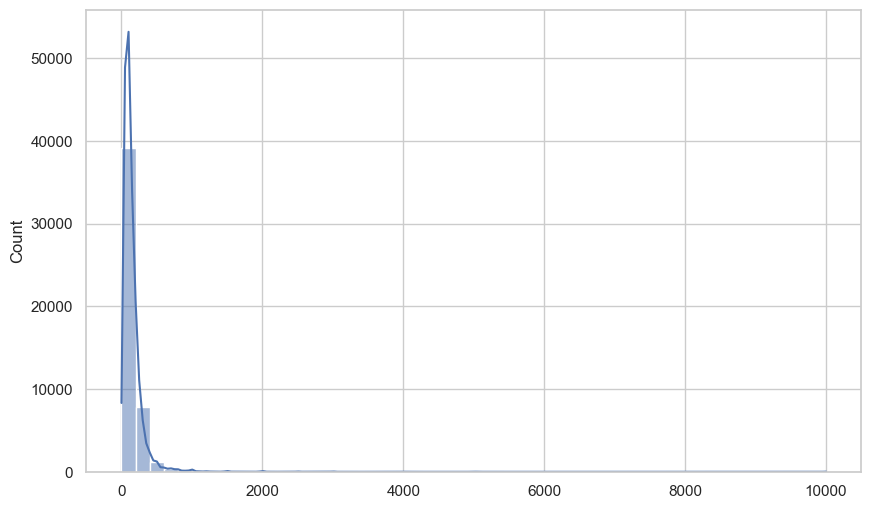

In [20]:
sns.histplot(price, bins=50, kde=True)

Dữ liệu tập trung vào nửa đầu của bin (0-2000), em sẽ dùng `np.log1p` để thể hiện lại biểu đồ để nhìn rõ hơn xu hướng.

<Axes: ylabel='Count'>

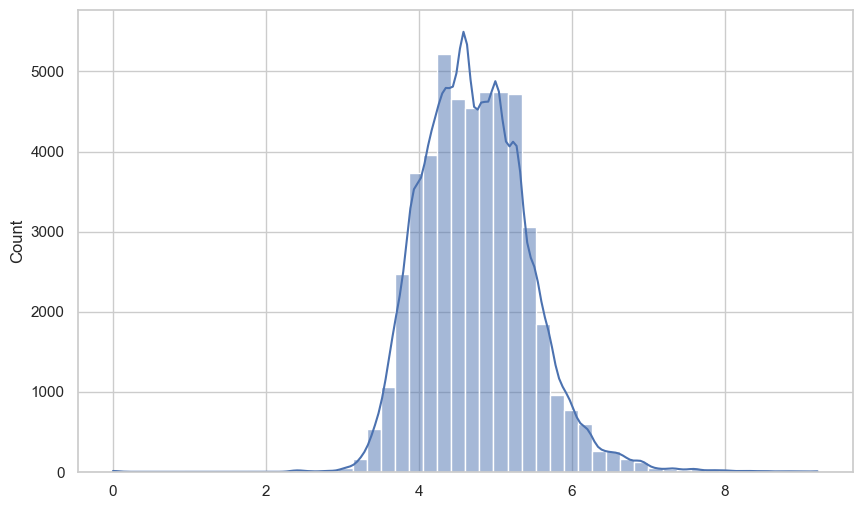

In [21]:
sns.histplot(np.log1p(price), bins=50, kde=True)

Bây giờ ta có thể thấy rõ hơn xu hướng dữ liệu. Giá tập trung nhiều ở khoảng (4, 6) trong thang log. Tức là giá thực tế tập trung nhiều ở khoảng (55, 400) đô la Mỹ.

*Bước **pre-processing** cần làm: Log-scale `price`.*

`minimum_nights` 

<Axes: ylabel='Count'>

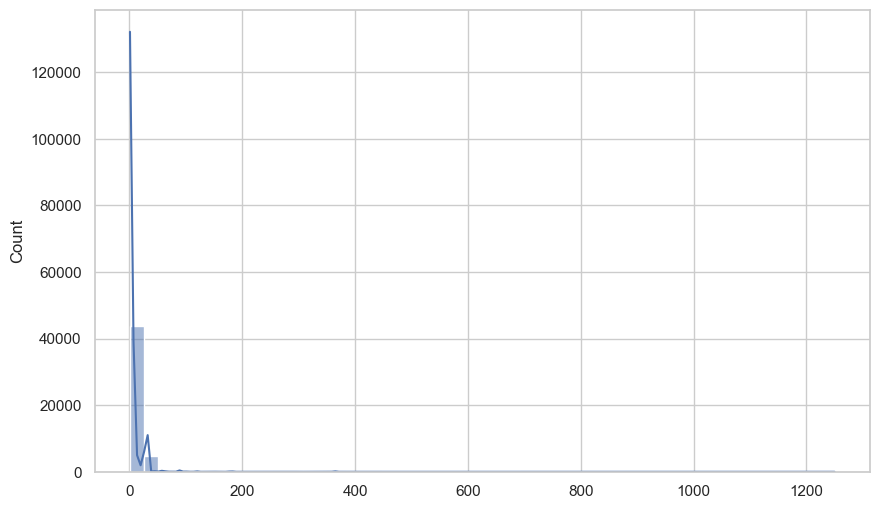

In [22]:
sns.histplot(min_nights, bins=50, kde=True)

Dữ liệu tập trung vào góc nhỏ đầu tiên của bin (0-200), em sẽ dùng `np.log1p` để thể hiện lại biểu đồ để nhìn rõ hơn xu hướng.

<Axes: ylabel='Count'>

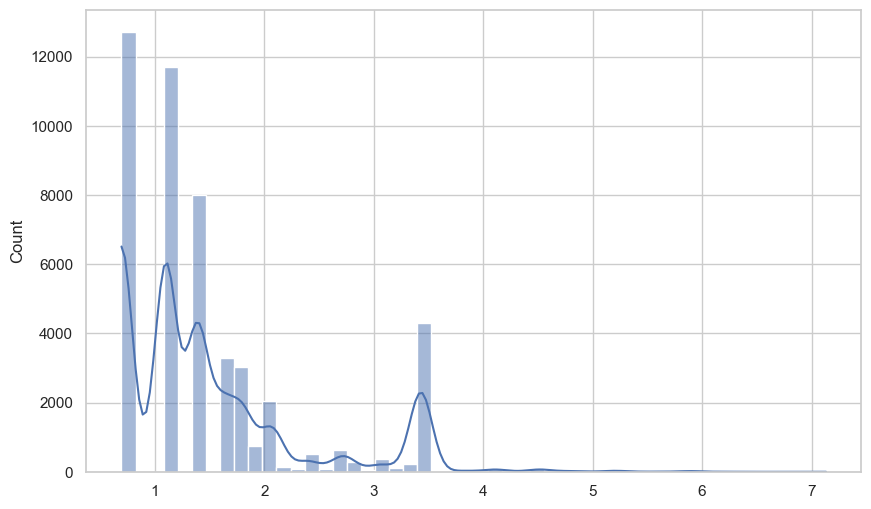

In [23]:
sns.histplot(np.log1p(min_nights), bins=50, kde=True)

`number_of_reviews`

<Axes: ylabel='Count'>

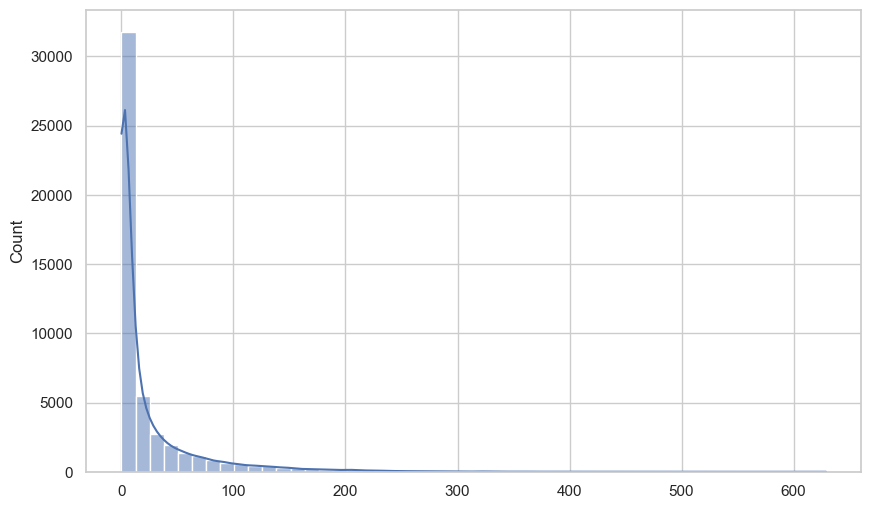

In [24]:
sns.histplot(n_reviews, bins=50, kde=True)

<Axes: ylabel='Count'>

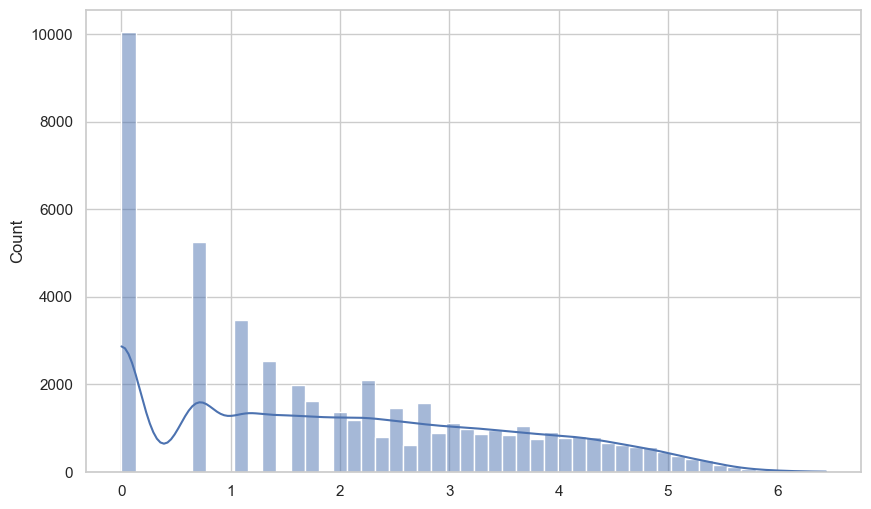

In [25]:
sns.histplot(np.log1p(n_reviews), bins=50, kde=True)

Dữ liệu có rất nhiều giá trị `0` với cột đầu tiên cao đột biến. Dù đã Log-scale, nhưng phân phối tổng thể vẫn lệch nặng.

**`room_type`** (Em thấy bar chart hợp cho thuộc tính này hơn Pie chart)

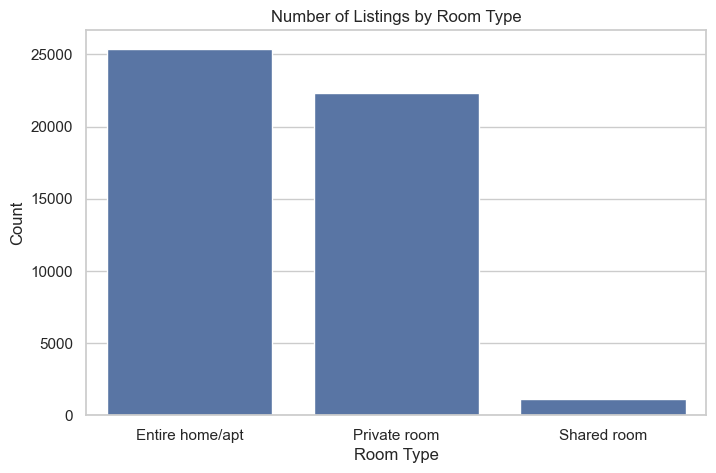

In [26]:
unique_room_types, counts = np.unique(room_type, return_counts=True)
plt.figure(figsize=(8, 5))
sns.barplot(x=unique_room_types, y=counts)
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.title('Number of Listings by Room Type')
plt.show()

Dữ liệu bị mất cân bằng. Entire home/apt và Private room chiếm áp đảo (>95%). Shared room rất ít.

*Bước **pre-processing** cần làm: Resampling dữ liệu cho quá trình **modeling**.*

### 4. Trực quan Đa biến

Mục đích: Xem yếu tố nào ảnh hưởng đến giá.

**Vị trí vs. Giá (Lat/Long vs Price)**

Tạm thời dùng log scale để nhìn xu hướng dữ liệu. Qua bước *pre-processing* ta sẽ xử lý

**Bản đồ New York City (Dataset cung cấp)**

![alt text](../data/raw/New_York_City_.png)

**Biểu diễn theo Scatter plot**

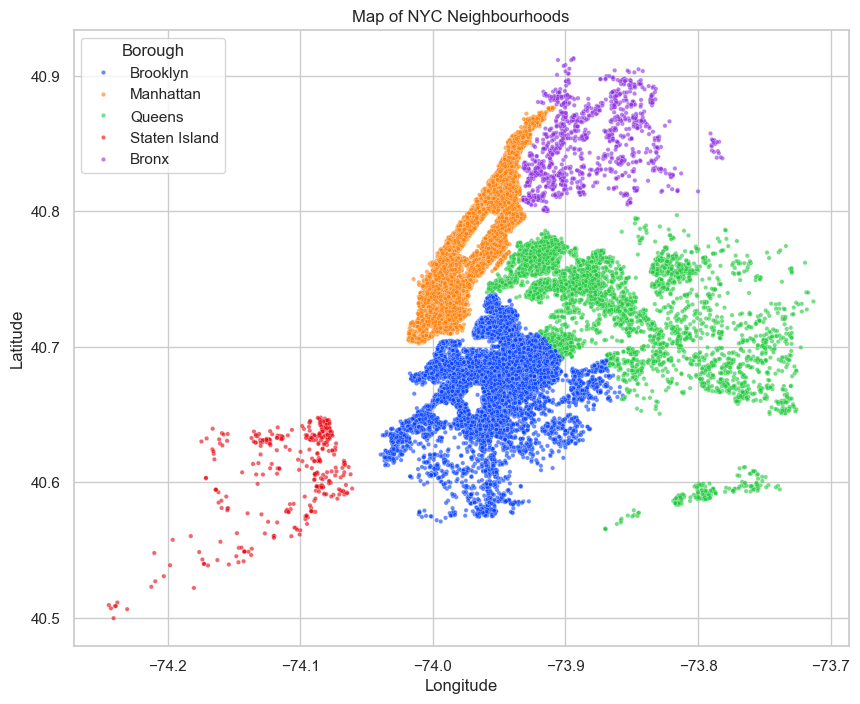

In [27]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=long, 
    y=lat, 
    hue=neigh_group, 
    palette='bright',
    s=10,
    alpha=0.6
)
plt.title('Map of NYC Neighbourhoods')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Borough')
plt.show()

- Manhattan:
  - **Vị trí:** Nằm giữa biểu đồ, là dải đất hẹp và dài. *(Longitude ~ -74.0 -> -73.9, Latitude ~ 40.7 -> 40.9)* 
  - **Đặc trưng trên hình:**  
    - Mật độ điểm *dày đặc nhất*.  
- Brooklyn:
  - **Vị trí:** Phía dưới và hơi lệch phải so với Manhattan. *(Longitude ~ -74.0 -> -73.85, Latitude ~ 40.6 -> 40.7)*  
  - **Đặc trưng trên hình:**  
    - Mật độ rất cao nhưng **trải rộng** hơn Manhattan.  
- Queens:
  - **Vị trí:** Bên phải Manhattan và Brooklyn. *(Longitude > -73.9)*  
  - **Đặc trưng trên hình:**  
    - Mật độ trung bình.  
- Bronx:
  - **Vị trí:** Phía trên Manhattan. *(Latitude > 40.8, Longitude -73.9 -> -73.8)*  
  - **Đặc trưng trên hình:**  
    - Một cụm điểm rõ rệt ở phía Bắc.  
    - Mật độ vừa phải.
- Staten Island:
  - **Vị trí:** Góc dưới bên trái biểu đồ. *(Longitude < -74.1, Latitude < 40.65)*  
  - **Đặc trưng trên hình:**  
    - Rất ít điểm.  
    - Tách hẳn khỏi phần còn lại của NYC.

**Bây giờ chúng ta sẽ xem Bản đồ này một lần nữa nhưng theo Giá**

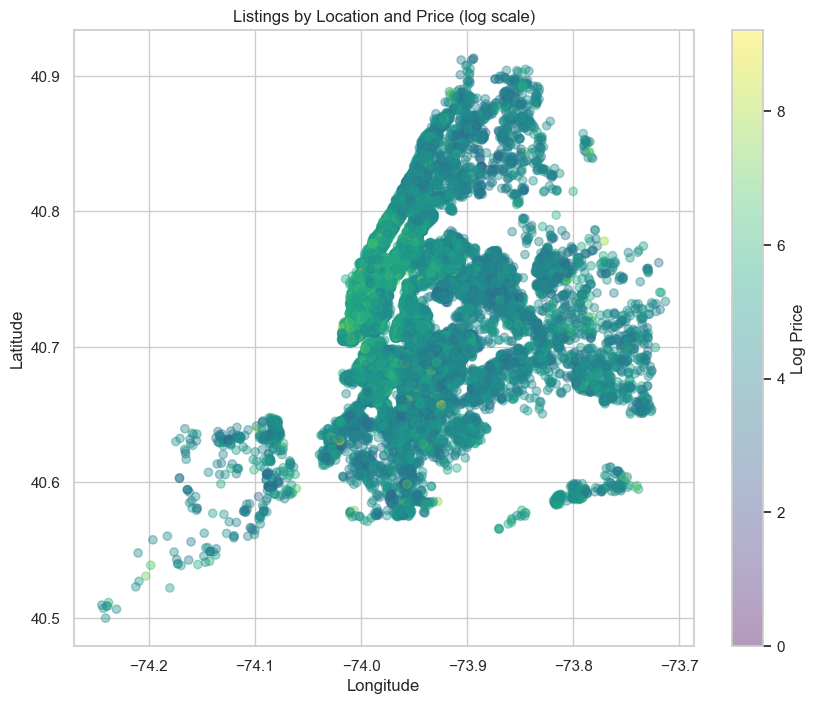

In [28]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    long, lat,
    c=np.log1p(price),
    cmap='viridis',
    alpha=0.4
)
plt.colorbar(scatter, label='Log Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Listings by Location and Price (log scale)')
plt.show()


**Nhận xét:**
- **Manhattan:** Mật độ dày và có giá cao nhất (Có màu xanh chúi xen vàng).  
- **Brooklyn, Queens:** Trải rộng với nhiều phân khúc giá.  
- **Bronx:** Cụm rõ ở phía Bắc, hầu hết các listing (điểm tròn trên biểu đồ) có màu xanh đậm (mức giá trung bình trên tổng thể).  
- **Staten Island:** Ít listing nhất, tách biệt với phần còn lại.

**Loại phòng vs. Giá (Room Type vs Price)**

Tạm thời dùng log scale để nhìn xu hướng dữ liệu. Qua bước *pre-processing* ta sẽ xử lý

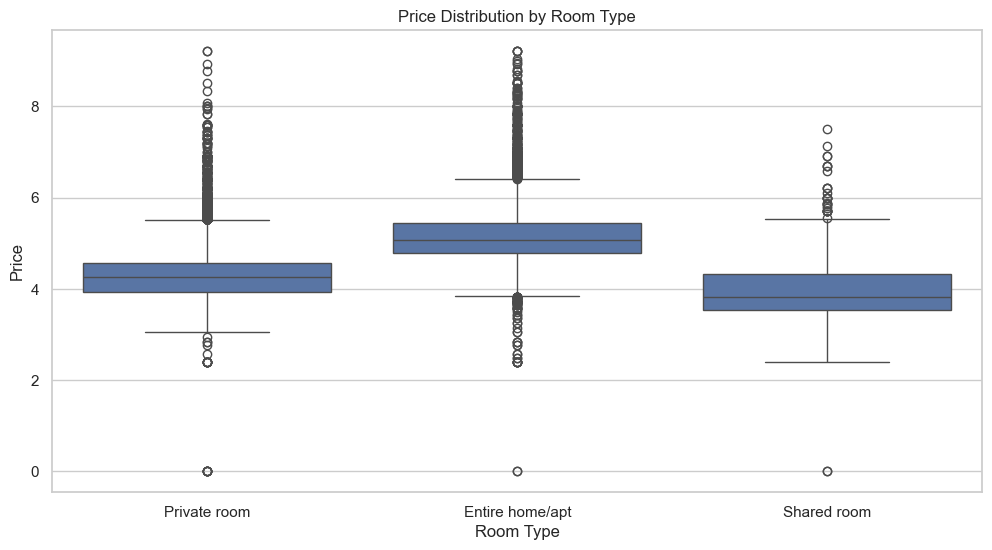

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=room_type, y=np.log1p(price))
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.title('Price Distribution by Room Type')
plt.show()

- Entire home/apt: Có mức giá trung bình cao nhất.
- Private room: Giá thấp hơn đáng kể.
- Shared room: Giá thấp nhất và biến động ít hơn.

*Bước **pre-processing** cần làm: One-Hot Encoding cho cột này.*

### 5. Phát hiện Outliers

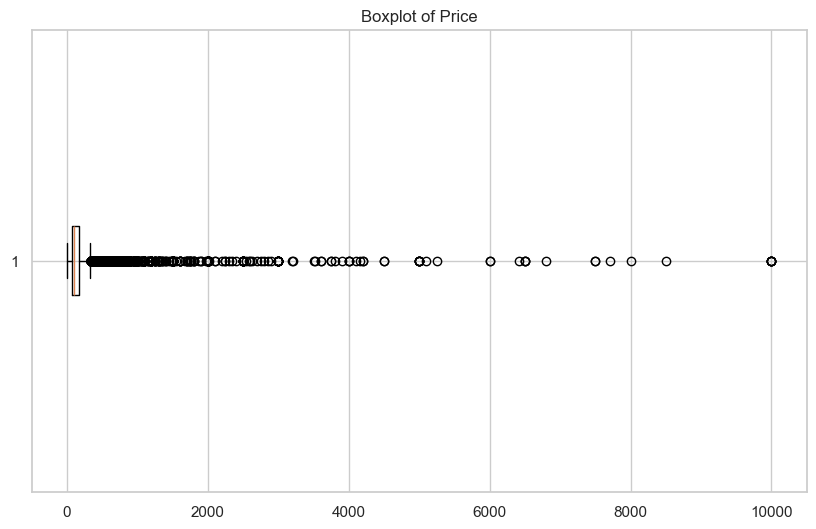

In [30]:
plt.boxplot(price, vert=False)
plt.title('Boxplot of Price')
plt.show()

- Cái "hộp" (Q1 -> Q3) bị nén bẹp dí ở sát lề trái (vùng giá thấp). Trong khi đó, dải Outliers kéo dài dằng dặc từ mốc ~500$ đến tận 10,000$.

*Bước **pre-processing** cần làm: em sẽ đặt ngưỡng cắt (Threshold) là 3 * (Q3 - Q1).*

### 5. Phân tích Tương quan

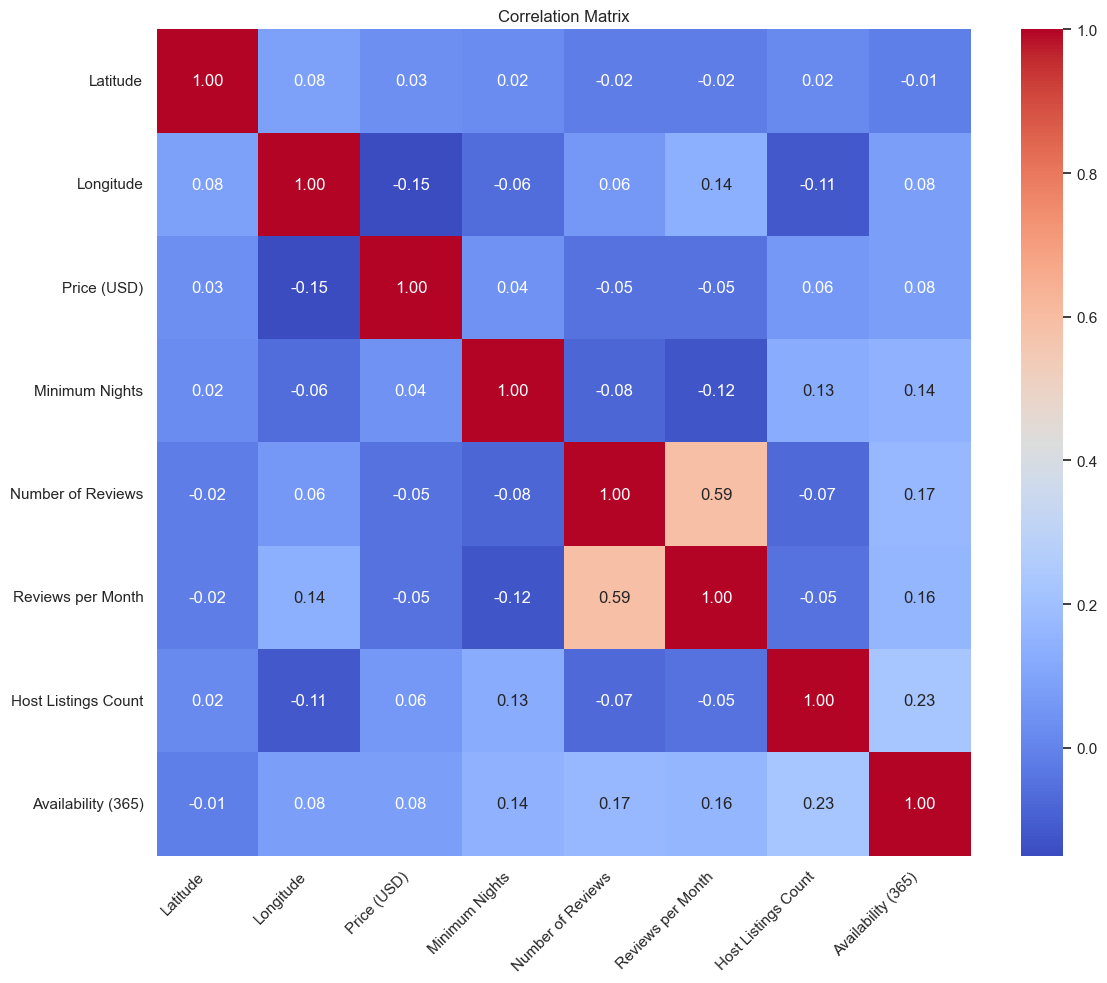

In [31]:
corr_matrix = np.corrcoef(num_data.T)

plt.figure(figsize=(12, 10))

labels = [
    'Latitude', 'Longitude', 'Price (USD)', 'Minimum Nights',
    'Number of Reviews', 'Reviews per Month', 'Host Listings Count', 'Availability (365)'
]

sns.heatmap(
    corr_matrix,
    annot=True, fmt=".2f", cmap='coolwarm',
    xticklabels=labels, yticklabels=labels
)

plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


**Qua Correlation Matrix, em nhận thấy (Do em sẽ liệt kê tất cả những mối quan hệ, chi tiết em nhìn thấy ở bước này để những bước pre-processing sau đó có ý nghĩa nên nó hơi dài):**
- Các thuộc tính nhìn chung không có tương quan mạnh (không có đa cộng tuyến); đa phần nằm trong khoảng ±0.15.
- `latitude` và `longitude` bản chất phi tuyến nên correlation matrix không nói được nhiều.
- `reviews_per_month` và `number_of_reviews` có tương quan cao nhất (0.589).
- Về `price`:
    - `price` gần như độc lập với các biến khác (tương quan cao nhất ~0.08).
    - Tương quan rất thấp với `availability` và `minimum_nights`.
    - Tương quan âm nhẹ với `number_of_reviews` và `reviews_per_month`.
- Về host:
    - `host_listings_count` có tương quan dương nhẹ với `minimum_nights` (0.128).
    - `host_listings_count` có tương quan dương với `availability` (0.2257).
- Về khách hàng:
    - `reviews_per_month` và `number_of_reviews` có tương quan mạnh (0.589).
    - `availability` có tương quan dương nhẹ với `reviews_per_month` và `neighbourhood_group`.

*Bước **pre-processing** cần làm:*
- Không cần loại bỏ nhiều biến do multicollinearity vì tương quan thấp.
- Thử nghiệm chỉ giữ 1 trong 2 thuộc tính: `reviews_per_month` và `number_of_reviews`.
- Feature engineering thêm biến mới (Do `price` không có mối liên hệ tuyến tính mạnh với các biến khác).
- Dùng `latitude`, `longitude` để tạo 1 feature mới liên quan hơn đến `price`.


## VI. LƯU DỮ LIỆU

In [32]:
#luu dữ liệu đã xử lý ra file mới
output_file = "../data/processed/AB_NYC_2019_exploration.csv"

src.write_data(output_file, data, columns)